In [2]:
pip install qiskit

In [4]:
pip install qiskit-ibm-runtime

In [5]:
pip install qiskit-aer

In [6]:
pip install scikit-learn

In [7]:
pip install qiskit qiskit-machine-learning

In [8]:
pip install pylatexenc

In [9]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [10]:
from qiskit.circuit import Parameter,ControlledGate
from qiskit_aer import AerSimulator
import qiskit
import numpy as np

In [11]:
from tqdm import tqdm

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
aersim = AerSimulator()
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 2000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = aersim

In [14]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [15]:
from qiskit import transpile, assemble

In [16]:
class QiskitCircuit():

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}

        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)

        self.circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i

        bound_params = {self.thetas[k]: params[k].item() for k in range(NUM_QUBITS)}
        transpiled_circuit = transpile(self.circuit, self.backend)
        qobj = assemble(transpiled_circuit, shots=self.shots, parameter_binds=[bound_params])

        job_sim = self.backend.run(qobj)
#
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

<ipython-input-16-dddcc3e3ecd3>:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_sim = self.backend.run(qobj)


Expected value for rotation [pi/4]: [0.     0.002  0.004  0.016  0.001  0.0155 0.0155 0.093  0.004  0.0135
 0.0135 0.087  0.016  0.0895 0.085  0.5445]


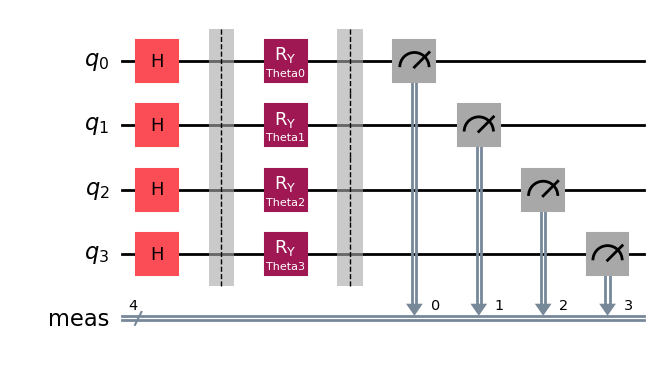

In [17]:
circuit = QiskitCircuit(NUM_QUBITS, aersim, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')

In [18]:
class TorchCircuit(Function):

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)

        exp_value = ctx.QiskitCirc.run(i)

        result = torch.tensor([exp_value])


        ctx.save_for_backward(result, i)

        return result

    @staticmethod
    def backward(ctx, grad_output):

        forward_tensor, i = ctx.saved_tensors

        input_numbers = i

        gradients = torch.Tensor()

        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])

            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

In [19]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

<ipython-input-16-dddcc3e3ecd3>:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_sim = self.backend.run(qobj)
<ipython-input-18-9770ca42621e>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  result = torch.tensor([exp_value])


y1 after quantum layer: tensor([[5.0000e-04, 2.0000e-03, 1.5000e-03, 1.4000e-02, 3.5000e-03, 1.3500e-02,
         1.6500e-02, 9.4000e-02, 2.5000e-03, 1.2000e-02, 1.8000e-02, 9.5500e-02,
         1.8000e-02, 8.5000e-02, 1.0050e-01, 5.2300e-01]], dtype=torch.float64,
       grad_fn=<TorchCircuitBackward>)
x.grad = tensor([0.0741, 0.0711, 0.0003, 0.0738])


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-16-dddcc3e3ecd3>:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_sim = self.backend.run(qobj)
100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


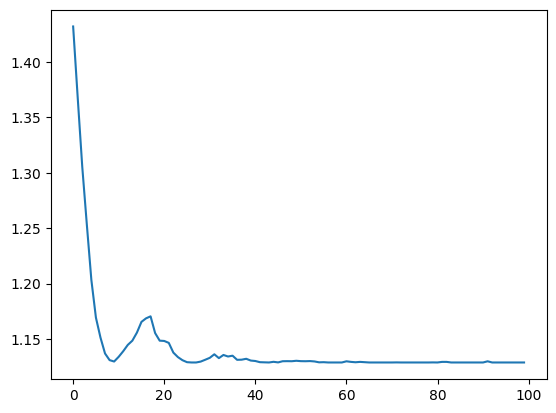

In [29]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]

    val = sum([(i+1)*expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS

    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

In [21]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

In [30]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Load the MNIST training dataset
n_samples = 150
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Select the first 150 samples from each class for training data
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx,
                np.where(X_train.targets == 7)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

# Load the MNIST test dataset
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# Select the first 150 samples from each class for test data
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx,
                np.where(X_test.targets == 7)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

# Load the diabetes dataset
df = pd.read_csv('dataset.csv')

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 2)
        self.fc3 = nn.Linear(2, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)

        MODE = 'QC' # 'QC' or 'QC_sim'

        if MODE == 'QC':
            x = qc(x[0]) # QUANTUM LAYER

        else:
            x = self.qcsim(x)

        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x

    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [32]:
epochs = 10
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())

    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

<ipython-input-16-dddcc3e3ecd3>:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_sim = self.backend.run(qobj)


Training [10%]	Loss: 3.4076
Training [20%]	Loss: 3.3494
Training [30%]	Loss: 3.3278
Training [40%]	Loss: 3.3204
Training [50%]	Loss: 3.3121
Training [60%]	Loss: 3.3097
Training [70%]	Loss: 3.3068
Training [80%]	Loss: 3.3050
Training [90%]	Loss: 3.3027
Training [100%]	Loss: 3.3006


Text(0, 0.5, 'Cross Entropy Loss')

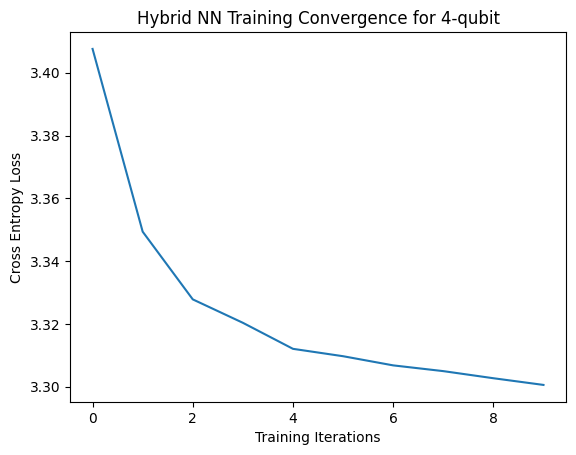

In [33]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

In [34]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

<ipython-input-16-dddcc3e3ecd3>:36: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_sim = self.backend.run(qobj)


In [35]:
print("Akurasi data adalah: {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Akurasi data adalah: 986/1200 = 82.16666666666667%
